In [123]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def coords_to_point(coords):
    from src.utils import MyNetCDF
    ncdf = MyNetCDF(path='../data/meta/land-exapmle-int.nc')
    return list(ncdf.coords_to_index(coords)[0].data)

def plotting(pred, y_test, model_data, years_test,title=None):
    
    # plotting settings

    fig, ax = plt.subplots()
    plt.gca().xaxis.grid(True, linestyle='--')
    
    dates = pd.date_range('01/01/{}'.format(years_test[0]), '31/12/{}'.format(years_test[-1])).to_pydatetime()

    ax.plot(dates, pred, label='Predictions')
    ax.plot(dates, y_test, label='Measurements',linewidth=2)
    ax.plot(dates, model_data, label = 'NEMO', alpha=0.8)
    
    ax.axhline(y=0, color='grey', linestyle='-')
    fig.legend()
    fig.autofmt_xdate()

    if title is not None: plt.title(title)
    plt.show()
    return plt

In [127]:
parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=[2014,2015],
                  X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[20, 20],
                  dx=5,
                  dy=5,
                  dt=5,
                  n_neurons=20,
                  epochs=70,
                  batch_size=30,
                  loss='mae'
                  )

filters = dict(partial_pca=10)
points = [[78,84],[80,-5],[73.6,162],[85,-180]]
point = coords_to_point(points[2])

model_data = data.load_variable_years('icethic_cea', parameters['years_test'], point)
y_true =data.load_variable_years(parameters['y_var'], parameters['years_test'], point)


In [128]:
y_arr_train, X_arr_train = data.load_features(parameters['y_var'],
                                              parameters['X_vars'],
                                              parameters['years_train'])

y_arr_test, X_arr_test = data.load_features(parameters['y_var'],
                                            parameters['X_vars'],
                                            parameters['years_test'])
mask = np.load(cfg.mask_path)

ft = fltr.FeatureTable(dx=parameters['dx'],
                       dy=parameters['dy'],
                       dt=parameters['dt'])

In [129]:
y_train = y_arr_train[:, point[0], point[1]]
y_test = y_arr_test[:, point[0], point[1]]
X_train = ft.gen_matrix(data=X_arr_train, x=point[0], y=point[1], filters=filters)
X_test = ft.gen_matrix(data=X_arr_test, x=point[0], y=point[1], filters=filters)

In [130]:
reg_params = dict(n_neurons=40,
                  epochs=50,
                  batch_size=15,
                  loss='mean_squared_error')

In [131]:
lstm = models.MyLSTM()
lstm.fit(X_train, y_train, parameters=reg_params)
pred = lstm.predict(X_test)

Epoch 1/50
 - 0s - loss: 1.0357
Epoch 2/50
 - 0s - loss: 0.4647
Epoch 3/50
 - 0s - loss: 0.2533
Epoch 4/50
 - 0s - loss: 0.1847
Epoch 5/50
 - 0s - loss: 0.1597
Epoch 6/50
 - 0s - loss: 0.1401
Epoch 7/50
 - 0s - loss: 0.1281
Epoch 8/50
 - 0s - loss: 0.1150
Epoch 9/50
 - 0s - loss: 0.1098
Epoch 10/50
 - 0s - loss: 0.1027
Epoch 11/50
 - 0s - loss: 0.1064
Epoch 12/50
 - 0s - loss: 0.1010
Epoch 13/50
 - 0s - loss: 0.0969
Epoch 14/50
 - 0s - loss: 0.0941
Epoch 15/50
 - 0s - loss: 0.0897
Epoch 16/50
 - 0s - loss: 0.0900
Epoch 17/50
 - 0s - loss: 0.0858
Epoch 18/50
 - 0s - loss: 0.0856
Epoch 19/50
 - 0s - loss: 0.0811
Epoch 20/50
 - 0s - loss: 0.0787
Epoch 21/50
 - 0s - loss: 0.0748
Epoch 22/50
 - 0s - loss: 0.0726
Epoch 23/50
 - 0s - loss: 0.0716
Epoch 24/50
 - 0s - loss: 0.0708
Epoch 25/50
 - 0s - loss: 0.0697
Epoch 26/50
 - 0s - loss: 0.0665
Epoch 27/50
 - 0s - loss: 0.0649
Epoch 28/50
 - 0s - loss: 0.0632
Epoch 29/50
 - 0s - loss: 0.0626
Epoch 30/50
 - 0s - loss: 0.0628
Epoch 31/50
 - 0s -

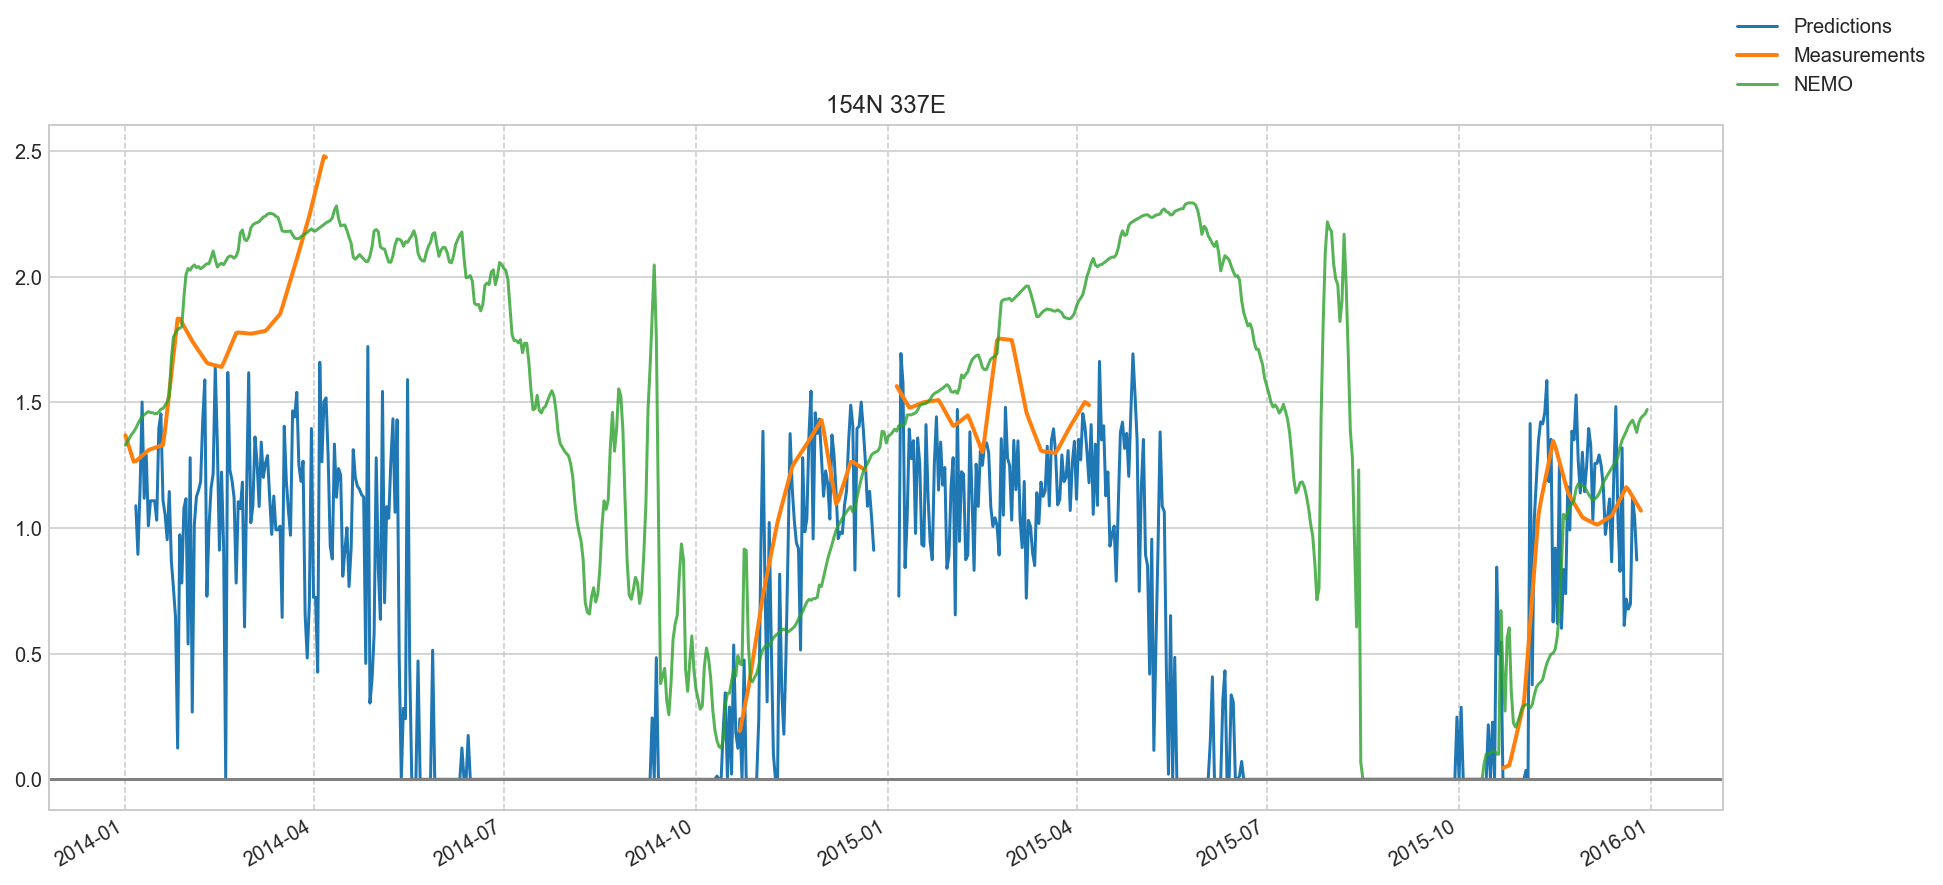

<module 'matplotlib.pyplot' from '/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [132]:
plotting(pred, y_true, model_data, parameters['years_test'], title = '{}N {}E'.format(point[0], point[1]))